In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as stat
import networkx as nx
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from glob import glob

In [2]:
# meta data includes the course title, run dates
AM_meta = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-meta.csv')
AM_meta

,id,metadata.display_name,category,metadata.start,metadata.end,metadata.enrollment_start,metadata.enrollment_end
0,MITxPRO+AMxB+1T2018,Additive Manufacturing for Innovative Design a...,course,2018-04-30 04:00:00,2018-07-02 23:30:00,2018-03-06,2018-05-11 23:30:00


In [3]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')
#AM_modules[:5]

In [4]:
# session level edge data
AM_edges_sessionLevel01 = pd.read_csv('data/MITxPRO+AMxB+1T2018/edges/MITxPRO+AMxB+1T2018-stdAgg-edgeList-sessionLevel-1.csv')
#AM_edges_sessionLevel01[AM_edges_sessionLevel01['user_id'] == 15779327][100:150]

3483

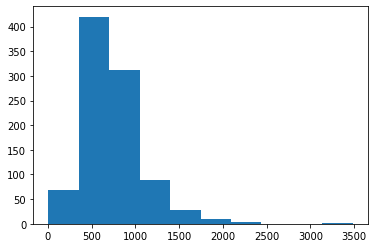

In [5]:
# for each student this is list of numerical id's for the URLs - removing duplicates
def get_trajectory(df):
    order = [0]
    for url in df['order']:
        if url != order[-1]:
            order.append(url)
    order.append(0)
    return order

trajectories = []

for fname in glob('data/MITxPRO+AMxB+1T2018/edges/*.csv'):
    df = pd.read_csv(fname)
    trajectories.append(df)
    
trajectories = pd.concat(trajectories)
trajectories = trajectories.groupby('user_id').apply(get_trajectory)
traj_lengths = trajectories.map(len).values

plt.hist(traj_lengths)
max(traj_lengths)
#trajectories[:25]

In [6]:
# incoming_traj = []
# outgoing_traj = []
# n_train = 800
# n_valid = 130

# for traj in trajectories.values:
#     incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
#     outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

# index = np.arange(len(trajectories))
# np.random.seed(9)
# np.random.shuffle(index)
    
# def train_generator():
#     while True:
#         for i in range(0, n_train):
#             x = incoming_traj[index[i]].reshape(1,-1)
#             y = outgoing_traj[index[i]].reshape(1,-1)
#             yield x,y
            
# def valid_generator():
#     while True:
#         for i in range(n_train, n_train+n_valid):
#             x = incoming_traj[index[i]].reshape(1,-1)
#             y = outgoing_traj[index[i]].reshape(1,-1)
#             yield x,y

In [7]:
# hidden_dim = 37
# embedding_dim = 30
# number_of_URL = 1121
# optimizer = Adam(learning_rate=0.001)

# input_ = Input(shape=(None,))
# embed = Embedding(number_of_URL, embedding_dim)(input_)

# rnn = LSTM(hidden_dim, return_sequences=True)(embed)

# predicted_URL = Dense(number_of_URL, activation = 'softmax')(rnn)

# model = Model(inputs=input_, outputs=predicted_URL)
# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
# model.summary()

In [8]:
incoming_traj = []
outgoing_traj = []
n_train = 800
n_valid = 130

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

#add data for pass/fail to status
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
status = np.where(AM_id_and_performance['certGrp']=='Certified (< 70% Grade)', 1, 0)
#status = AM_id_and_performance[AM_id_and_performance['certGrp']=='Certified (< 70% Grade)']
    
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)
    
def train_generator():
    while True:
        for i in range(0, n_train):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #s = status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y
            
def valid_generator():
    while True:
        for i in range(n_train, n_train+n_valid):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            #s = status[index[i]].reshape(1,-1)
            y = outgoing_traj[index[i]].reshape(1,-1)
            yield [x,s],y
            
#status[:5]

In [9]:
hidden_dim = 37
embedding_dim = 30
number_of_URL = 1121
optimizer = Adam(learning_rate=0.001)

input_x = Input(shape=(None,))
input_s = Input(shape=(None,))
embed_x = Embedding(number_of_URL, embedding_dim)(input_x)
embed_s = Embedding(2, hidden_dim, weights=[np.ones((2, hidden_dim))])(input_s)

rnn = LSTM(hidden_dim, return_sequences=True)(embed_s)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax')(masked)

model = Model(inputs=[input_x, input_s], outputs=predicted_URL)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 37)     74          input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 37)     11100       embedding_1[0][0]                
__________________________________________________________________________________________________
multiply (Multiply)             (None, None, 37)     0           lstm[0][0]                       
                                                                 embedding_1[0][0]            

In [19]:
#model.save_weights('weights_version01.h5')

In [12]:
model.load_weights('MITxPRO+AMxB+1T2018_weights_version01.h5')
model.fit_generator(train_generator(), 
                    validation_data=valid_generator(),
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=10,
                    verbose=1,)

ValueError: Shapes (2, 37) and (1121, 30) are incompatible

In [44]:
# user list key - session level
AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
AM_userList

# learning pathway network edge lists - edge list for each student in the course that represent a directed 
# transitions networks  of students pathway through the courses content modules.  this is all students.
AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
AM_edgelist[:5]

In [12]:
incoming_traj[0].shape

(1, 492)

In [21]:
model.predict([[0,1,3,4,5,6],[0,0,0,0,0,0]])[0,-1].tolist()

[0.09469149261713028,
 0.0007556013879366219,
 0.03790721669793129,
 0.0003009327920153737,
 0.005466002505272627,
 0.16386127471923828,
 0.03442411869764328,
 0.0780443400144577,
 0.536535918712616,
 0.0062783933244645596,
 0.0002524536394048482,
 0.004515466280281544,
 1.182973210234195e-05,
 8.965464985521976e-06,
 1.989750671782531e-05,
 3.419453946662543e-07,
 1.8848023728423868e-06,
 2.944901461887639e-05,
 7.182717672549188e-05,
 2.2748103219782934e-05,
 2.587056405900512e-05,
 0.00011965393059654161,
 1.4792369256610982e-05,
 1.472776478550486e-08,
 1.1163672752445564e-05,
 1.7826033982260014e-08,
 6.694157406172963e-08,
 8.908149538910948e-06,
 0.001075154752470553,
 2.940822241725982e-06,
 0.00011084252037107944,
 2.5211727461282862e-06,
 3.1981469419406494e-06,
 1.0662914746717433e-06,
 1.5298475773306563e-05,
 1.4459938135757966e-08,
 2.515821734050405e-06,
 1.2647136600207887e-06,
 8.09261928225169e-06,
 9.009478162624873e-06,
 1.8577335140435025e-05,
 3.138146894343663e-0

In [8]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

,id,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,401ee1f6f3684be7b6124490f34adc5a,MITxPRO+AMxB+1T2018,html,1,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,907,2300
1,27bf430c96cb4d8da7368c4697de187b,MITxPRO+AMxB+1T2018,html,2,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,922,1853
2,0fec97a46b71456d9d9037e5edac7bb0,MITxPRO+AMxB+1T2018,html,3,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,26,29
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,MITxPRO+AMxB+1T2018,problem,4,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,9546e9f7f20c4bf2b09c7c839fd67571,930,5195
4,04d85100616943f8a3d2b084f403ba5f,MITxPRO+AMxB+1T2018,html,5,3e2b8f40ac004d56a2e85e503e0e635b,b4100fe285a442a2ba6de2e94b28642b,6fddc8e62a094b818e30327c45ebf7f3,928,2750
...,...,...,...,...,...,...,...,...,...
750,5b42266d225e4a83bcf7833af7143417,MITxPRO+AMxB+1T2018,html,751,476998cc999c4312b392d128c14cab9b,2c093467e9d54014a0d4f00f7abf931c,71d13483bea1443e83f02d4b036c404e,560,1739
751,253c3d95e42f47a192997f25c3fd5881,MITxPRO+AMxB+1T2018,html,752,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,cc2f936f1afc4df0bb4bf7fa943b1d97,788,2567
752,7d262be6d9b74836b47447db1b70289d,MITxPRO+AMxB+1T2018,problem,753,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,c3e12647605f4894ab69df903b567bf2,774,4682
753,024fed17849e4d60bfc86afa47ce9cb4,MITxPRO+AMxB+1T2018,html,754,4022bcb994a3447a9c609f4ce5bd9016,9852b66b25d14ec0b379bc6532e1753c,e4cd156124f04c1ab2c7fbeead3afa35,0,0


In [9]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chpModLabel,seqModLabel,In-Degree,Out-Degree,Degree
0,401ee1f6f3684be7b6124490f34adc5a,1594.1262f,1048.7539f,MITxPRO+AMxB+1T2018,html,1,907,2300,"Entrance Survey (5 min, required)",Entrance Survey-Html,16,14,30
1,27bf430c96cb4d8da7368c4697de187b,1580.7435f,1018.63403f,MITxPRO+AMxB+1T2018,html,2,922,1853,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,10,8,18
2,0fec97a46b71456d9d9037e5edac7bb0,1598.8334f,1135.2795f,MITxPRO+AMxB+1T2018,html,3,26,29,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,2,2,4
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,1549.503f,1036.6296f,MITxPRO+AMxB+1T2018,problem,4,930,5195,"Pre-Assessment (10 min, required)",Pre-Assessment Completion Confirmation,5,7,12
4,04d85100616943f8a3d2b084f403ba5f,1505.2043f,1015.3352f,MITxPRO+AMxB+1T2018,html,5,928,2750,Get Started (25 min),Welcome-Html,19,14,33


In [9]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

array(['Not certified (> 70% Grade)', 'Certified (< 70% Grade)'],
      dtype=object)

In [11]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

,id,metadata.display_name,category,metadata.start,metadata.end
0,MITxPRO+LASERxB1+1T2019,"Strategy, Products, Capability Work, and Teams",course,2019-03-09 01:00:00,2019-04-09 23:59:00


In [12]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

# LaaL_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [13]:
LaaL_edelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

,from,to,stds,weight,dis,sl
0,001339db8ced4cf78829ebe8b145449d,001339db8ced4cf78829ebe8b145449d,179,1096,0,1
1,001339db8ced4cf78829ebe8b145449d,452745e0366e42ae81561bfddebcc6c3,177,179,1,0
2,001339db8ced4cf78829ebe8b145449d,4660ff2089114e8db82ceb26a4f329e3,2,2,2,0
3,001339db8ced4cf78829ebe8b145449d,901e92500aea43c79f19f1b279050668,4,4,-1,0
4,00ae5f0c51874a73a41ebea838d95682,00ae5f0c51874a73a41ebea838d95682,119,383,0,1


In [14]:
LaaL_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

,name,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,b613861cecf84ffcab01afb23f660475,MITxPRO+LASERxB1+1T2019,problem,1,41ad78dff2594088a4eb8b6b7ce406f3,c1b52a1ef69a404ea9132e95ad25093a,4aea5151404640ac8ebe81deff85def0,241,1610
1,e2911e79efc2420eac45d9f671463d4b,MITxPRO+LASERxB1+1T2019,problem,2,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,1686
2,519d1b8c59404d67b54e96c5c8a830b2,MITxPRO+LASERxB1+1T2019,problem,3,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,592
3,531db53f81f646edb0cdcfe0085b03b7,MITxPRO+LASERxB1+1T2019,problem,4,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,566
4,4f5f94b2f95141e0a9d53a61da2276da,MITxPRO+LASERxB1+1T2019,problem,5,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,571


In [15]:
LaaL_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chapterModLabel,In-Degree,Out-Degree,Degree
0,b613861cecf84ffcab01afb23f660475,-882.02423f,2054.1257f,MITxPRO+LASERxB1+1T2019,problem,1,241,1610,Week 0: Get Started (40 min),22,23,45
1,e2911e79efc2420eac45d9f671463d4b,-758.68823f,2250.8474f,MITxPRO+LASERxB1+1T2019,problem,2,241,1686,Week 0: Get Started (40 min),23,21,44
2,519d1b8c59404d67b54e96c5c8a830b2,-902.5562f,2516.3157f,MITxPRO+LASERxB1+1T2019,problem,3,241,592,Week 0: Get Started (40 min),5,7,12
3,531db53f81f646edb0cdcfe0085b03b7,-943.9201f,2620.5632f,MITxPRO+LASERxB1+1T2019,problem,4,241,566,Week 0: Get Started (40 min),5,5,10
4,4f5f94b2f95141e0a9d53a61da2276da,-963.7683f,2726.7637f,MITxPRO+LASERxB1+1T2019,problem,5,241,571,Week 0: Get Started (40 min),5,8,13


In [16]:
LaaL_id_and_performance = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

,id,percent_grade,date_joined,enroll_created_date,cert_status,certGrp
0,11686401,0.38,8/23/2016 22:41,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
1,15603897,0.02,8/14/2017 13:53,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
2,11382474,0.40,7/22/2016 12:46,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
3,20757153,0.02,9/17/2018 17:15,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
4,11615808,0.34,8/16/2016 20:59,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
